In [60]:
import numpy as np


In [61]:
# test final files
import h5py

def print_hdf5_structure(group, indent=0):
    """遞迴列出 HDF5 檔案結構"""
    for key in group.keys():
        print(" " * indent + "📂 " + key)
        if isinstance(group[key], h5py.Group):  # 如果是群組，繼續遞迴
            print_hdf5_structure(group[key], indent + 2)

file_path = "/work/DATA/Satellite/IMERG_daily/IMERG_2000.nc"

# 使用 with 確保檔案開啟狀態
with h5py.File(file_path, "r") as f:
    print("📌 檔案結構：")
    print_hdf5_structure(f)
    precip = f["precipitation"][:] # mm/
    
    


📌 檔案結構：
📂 lat
📂 lon
📂 precipitation
📂 time


In [62]:
file_path = r"/data92/PeterChang/Paper2/IMERG_from_kai/precipitation_2001_2021_anomaly.nc"
with h5py.File(file_path, "r") as f:
    precip = f["precipitation"][:]  # 讀取降水數據


In [63]:
precip.shape

(7670, 360, 576)

In [91]:
# file_path = r"/data92/PeterChang/Paper2/Reanalysis/u/u_all_level_anomaly.nc"
file_path = "/data92/PeterChang/Paper2/Reanalysis/u_kai/ubaro_2001_2022_anomaly.nc"

with nc.Dataset(file_path, "r") as f:
    print(f)
    u_all = f["ubaro"][:]  # 讀取降水數據


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    CDI: Climate Data Interface version 1.9.7.1 (http://mpimet.mpg.de/cdi)
    Conventions: CF-1.6
    history: Fri Feb 28 14:28:14 2025: cdo ydaysub outfile climatology_3harmonics.nc ubaro_2001_2022_anomaly.nc
Fri Feb 28 14:27:56 2025: cdo mergetime ubaro_2001.nc ubaro_2002.nc ubaro_2003.nc ubaro_2004.nc ubaro_2005.nc ubaro_2006.nc ubaro_2007.nc ubaro_2008.nc ubaro_2009.nc ubaro_2010.nc ubaro_2011.nc ubaro_2012.nc ubaro_2013.nc ubaro_2014.nc ubaro_2015.nc ubaro_2016.nc ubaro_2017.nc ubaro_2018.nc ubaro_2019.nc ubaro_2020.nc ubaro_2021.nc outfile
    CDO: Climate Data Operators version 1.9.7.1 (http://mpimet.mpg.de/cdo)
    dimensions(sizes): time(7670), lon(576), lat(360)
    variables(dimensions): float64 time(time), float64 lon(lon), float64 lat(lat), float32 ubaro(time, lat, lon)
    groups: 


In [94]:
u_all.shape

(7670, 360, 576)

In [23]:
import numpy as np

In [68]:
print("u_all min:", np.min(u_all))
print("u_all max:", np.max(u_all))


u_all min: -50.270615
u_all max: 45.35325


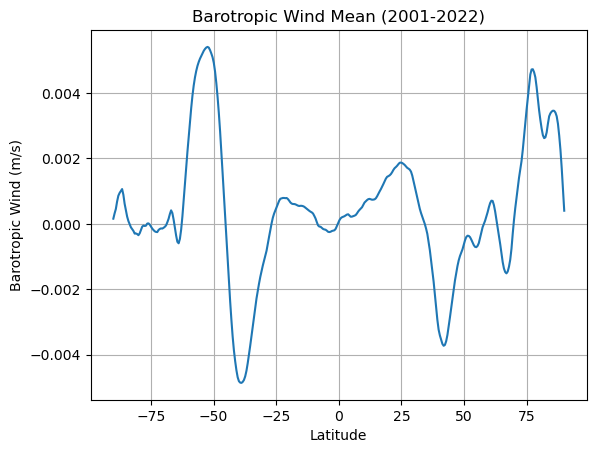

In [69]:
# **繪製氣壓加權平均風速的緯度剖面**
lat_coarse = np.linspace(-90,90,360)
plt.figure()
plt.plot(lat_coarse, u_all[:].mean(axis=(0,2)))
plt.xlabel("Latitude")
plt.ylabel("Barotropic Wind (m/s)")
plt.title("Barotropic Wind Mean (2001-2022)")
plt.grid()
plt.show()

-50.270615


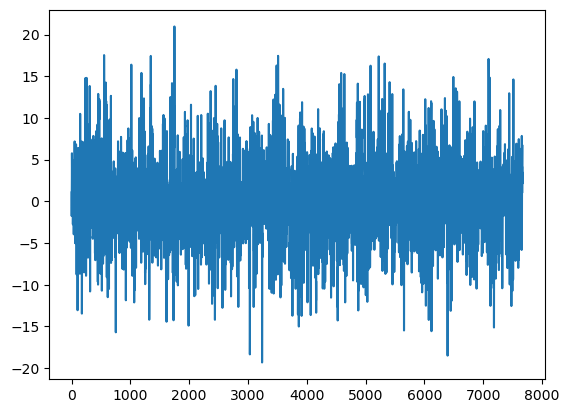

In [70]:
plt.figure()
plt.plot(u_all[:,0,0])
print(u_all.min())

# Find u after large-scale precipitation

In [2428]:
import numpy as np

# 獲取緯度範圍 (範圍 -20° ~ 20°)
lat_coarse = np.linspace(-90,90,360)
lat_tropic = (lat_coarse >= -10) & (lat_coarse <= 10)  # ✅ 修正布林索引

# 選取該範圍內的降水數據
precip_tropic = precip[:, lat_tropic, :] * np.cos(np.deg2rad(lat_coarse[lat_tropic]))[np.newaxis, :,np.newaxis] **0.5   # ✅ 使用布林索引選取

# 計算經度平均 (Zonal Mean, 沿著 axis=1 方向計算)
precip_tropic_zonal_mean = np.average(precip_tropic, axis=(1,2)) #.mean(axis=(1,2))  # ✅ 計算熱帶區域的經向平均




In [2429]:
print(precip_tropic.shape)
print(precip_tropic_zonal_mean.shape)


(7670, 40, 576)
(7670,)


In [2430]:
# 計算極端降水事件 (均值 + 2σ)
mean_precip = np.nanmean(precip_tropic_zonal_mean)
std_precip  = np.nanstd(precip_tropic_zonal_mean)   
extreme_threshold          = mean_precip + 1 * std_precip    # 
extreme_threshold_2std     = mean_precip + 2 * std_precip    # 

extreme_threshold_dry = mean_precip - 1 * std_precip    # 


# 選出超過閾值的降水事件
extreme_precip = precip_tropic_zonal_mean[precip_tropic_zonal_mean > extreme_threshold]
extreme_dry    = precip_tropic_zonal_mean[precip_tropic_zonal_mean < extreme_threshold_dry]


print("📌 極端降水事件數:", extreme_precip.shape[0])
print("✅ 極端降水計算完成！")

print("📌 極端乾旱事件數:", extreme_dry.shape[0])
print("✅ 極端降水計算完成！")

📌 極端降水事件數: 1197
✅ 極端降水計算完成！
📌 極端乾旱事件數: 1197
✅ 極端降水計算完成！


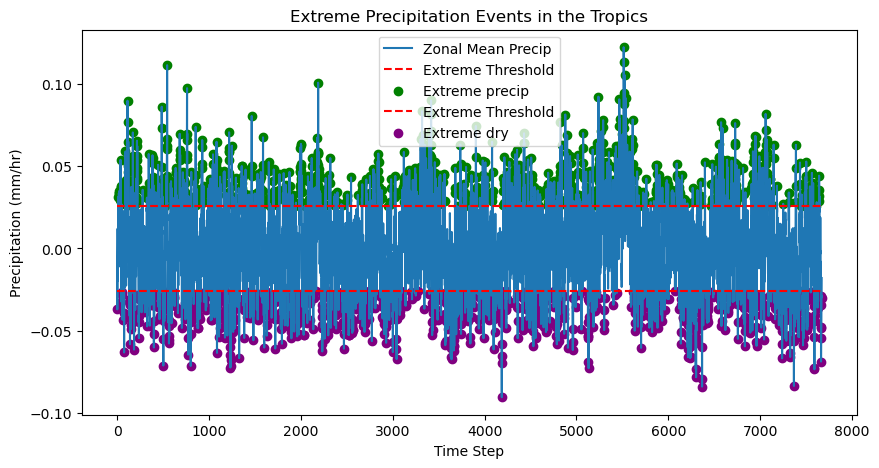

In [2431]:
import matplotlib.pyplot as plt
import numpy as np

# 先找出 `extreme_precip` 的索引
extreme_indices       = np.where(precip_tropic_zonal_mean > extreme_threshold)[0]
extreme_indices_2std  = np.where(precip_tropic_zonal_mean > extreme_threshold_2std)[0]


extreme_indices_dry = np.where(precip_tropic_zonal_mean < extreme_threshold_dry)[0]


plt.figure(figsize=(10, 5))
plt.plot(precip_tropic_zonal_mean, label="Zonal Mean Precip")  # 主要降水數據
plt.hlines(y=extreme_threshold, xmin=0, xmax=len(precip_tropic_zonal_mean)-1, color="red", linestyle="dashed", label="Extreme Threshold")  # 閾值線
plt.scatter(extreme_indices, extreme_precip, color="Green", label="Extreme precip")  # 正確的索引 & 數據點

plt.hlines(y=extreme_threshold_dry, xmin=0, xmax=len(precip_tropic_zonal_mean)-1, color="red", linestyle="dashed", label="Extreme Threshold")  # 閾值線
plt.scatter(extreme_indices_dry, extreme_dry, color="Purple", label="Extreme dry")  # 正確的索引 & 數據點

plt.xlabel("Time Step")
plt.ylabel("Precipitation (mm/hr)")
plt.legend()
plt.title("Extreme Precipitation Events in the Tropics")
plt.show()


In [2432]:
u_all.shape

(7670, 360, 576)

In [2433]:
lag = 10
extreme_indices_lag     = extreme_indices + lag
extreme_indices_dry_lag = extreme_indices_dry + lag


extreme_indices_lag     = extreme_indices_lag[extreme_indices_lag < int(u_all.shape[0]-lag)]
extreme_indices_dry_lag = extreme_indices_dry_lag[extreme_indices_dry_lag<int(u_all.shape[0]-lag)]

print(u_all[extreme_indices_lag].shape)
print(u_all[extreme_indices_dry_lag].shape)


(1197, 360, 576)
(1190, 360, 576)


In [2434]:
final_u     = u_all[extreme_indices_lag].mean(axis=(0,2))
final_u_dry = u_all[extreme_indices_dry_lag].mean(axis=(0,2))


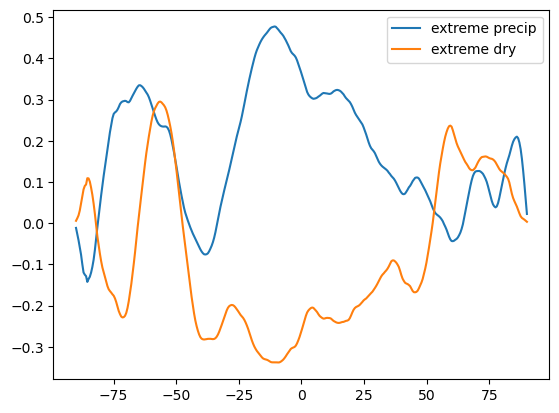

In [2435]:
plt.figure()
plt.plot(lat_coarse, final_u, label="extreme precip")
plt.plot(lat_coarse, final_u_dry, label="extreme dry")
# plt.plot(lat_coarse, final_u - final_u_dry, label="wet - dry")


plt.legend()

In [2376]:
import numpy as np
import matplotlib.pyplot as plt

# 設定 lag 範圍
lag_range = np.arange(5, 21)  # 5~20 天

# 初始化累積變數
final_u_sum = np.zeros((u_all.shape[1],))  # (lat,)
final_u_dry_sum = np.zeros((u_all.shape[1],))

# 計算不同 lag 的 composite
for lag in lag_range:
    extreme_indices_lag = extreme_indices + lag
    extreme_indices_dry_lag = extreme_indices_dry + lag

    # 避免超過數據範圍
    extreme_indices_lag = extreme_indices_lag[extreme_indices_lag < int(u_all.shape[0] - lag)]
    extreme_indices_dry_lag = extreme_indices_dry_lag[extreme_indices_dry_lag < int(u_all.shape[0] - lag)]

    # 計算 composite
    final_u_lag = u_all[extreme_indices_lag].mean(axis=(0, 2))  # (lat,)
    final_u_dry_lag = u_all[extreme_indices_dry_lag].mean(axis=(0, 2))

    # 累積結果
    final_u_sum += final_u_lag
    final_u_dry_sum += final_u_dry_lag

# 計算平均
final_u_avg = final_u_sum / len(lag_range)
final_u_dry_avg = final_u_dry_sum / len(lag_range)




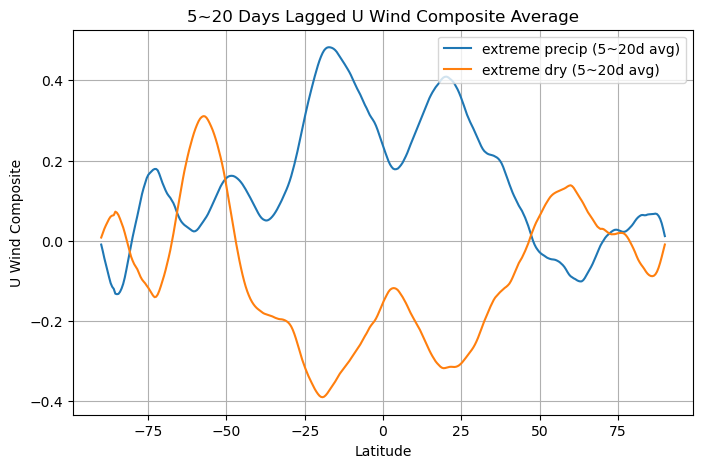

In [2377]:
# 繪圖
plt.figure(figsize=(8, 5))
plt.plot(lat_coarse, final_u_avg, label="extreme precip (5~20d avg)")
plt.plot(lat_coarse, final_u_dry_avg, label="extreme dry (5~20d avg)")
plt.xlabel("Latitude")
plt.ylabel("U Wind Composite")
plt.title("5~20 Days Lagged U Wind Composite Average")
plt.legend()
plt.grid()
plt.show()

#  Autocorrelation

In [2378]:
# # file_path = r"/data92/PeterChang/Paper2/Reanalysis/u/u_all_level_anomaly.nc"
# file_path = "/data92/PeterChang/Paper2/Reanalysis/u_kai/outfile"

# with nc.Dataset(file_path, "r") as f:
#     print(f)
#     u_original = f["ubaro"][:]  # 讀取降水數據


In [2379]:
u_all.shape

(7670, 360, 576)

In [2380]:
barotropic_u_zonal_mean = u_all.mean(axis=2)

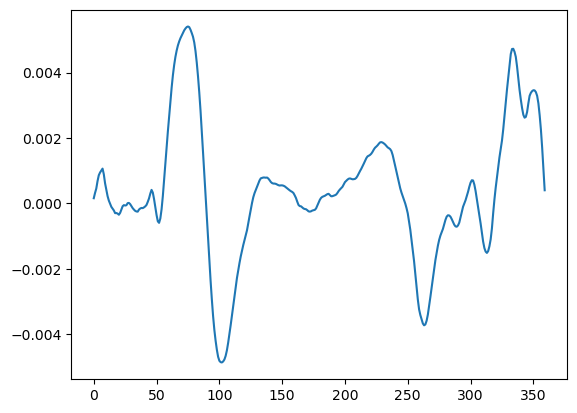

In [2381]:
plt.figure()
plt.plot(barotropic_u_zonal_mean[:,:].mean(axis=0))

In [2582]:
# Select time index
def Cal_EOF_PC_for_barotropic(input_data):
    from EOF import EOF
    # input : (time, y)
    
    # Perform latitude weighting
    input_data_weighted = input_data * np.sqrt(np.cos(np.deg2rad(np.linspace(-90, 0, input_data.shape[1]))))

    # Initialize an EOF instance with weighted input data
    n_component = min(input_data.shape[0], input_data.size // input_data.shape[0])

    print("n_component:", n_component)
    eof_instance = EOF((input_data_weighted,), n_components=n_component, field="1D")
    
    # Compute EOFs and PCs
    eof_instance.get()
    
    # Retrieve EOFs and PCs and Extract EOF1, PC1, EOF2, and PC2
    EOF1, EOF2 = eof_instance.EOF[:2]
    PC1, PC2 = eof_instance.PC[:2]

    # Normalize PCs and EOFs
    PC1_norm, PC2_norm = PC1 / PC1.std(), PC2 / PC2.std()
    EOF1_norm, EOF2_norm = EOF1 * PC1.std(), EOF2 * PC2.std()
    
    return EOF1_norm, PC1_norm, EOF2_norm, PC2_norm

In [2583]:
print(barotropic_u_zonal_mean.shape)
EOF1, PC1, EOF2, PC2 = Cal_EOF_PC_for_barotropic(barotropic_u_zonal_mean[:,:180])

(7670, 360)
n_component: 180


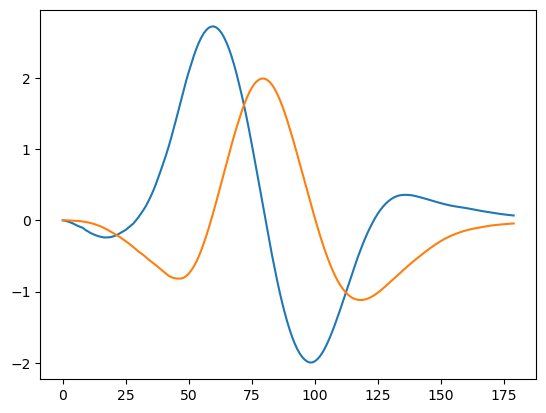

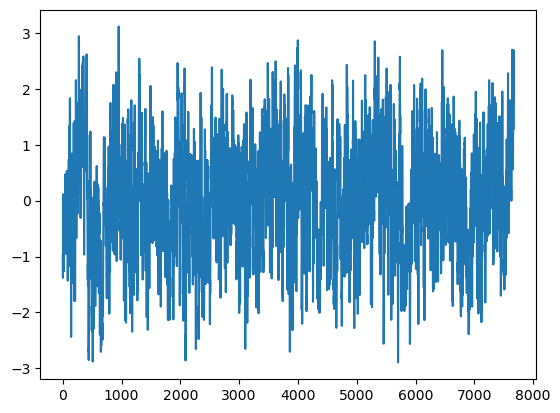

In [2584]:
plt.figure()
plt.plot(EOF1)
plt.plot(-EOF2)
plt.figure()
plt.plot(PC1)


In [2436]:
import numpy as np

def autocorr(x, lags, split_to_chunk=False, window_length=None, overlap_ratio=0.5, avg_chunks=True):
    """
    計算自相關函數 (Auto-correlation Function, ACF)。
    
    參數：
    - x : array-like
        輸入數據。
    - lags : int
        要計算的時間滯後 (lag) 數量。
    - split_to_chunk : bool, 默認 False
        是否將數據分割成子窗口進行計算。
    - window_length : int, 默認 None
        如果 split_to_chunk=True，則需要提供每個窗口的長度。
    - overlap_ratio : float, 默認 0.5
        窗口之間的重疊比例 (0.0 表示無重疊, 0.5 表示 50% 重疊)。
    - avg_chunks : bool, 默認 True
        如果 split_to_chunk=True，是否對不同窗口的結果取平均。

    返回：
    - autocorrs : np.array
        計算出的自相關函數值，形狀為 (lags,) 或 (window_number, lags)。
    """
    
    x = np.asarray(x)  # 確保 x 是 NumPy 陣列
    N = len(x)

    if not split_to_chunk:
        # 直接計算全域自相關
        autocorrs = np.array([1.0 if l == 0 else np.corrcoef(x[:-l], x[l:])[0, 1] for l in range(lags)])
        return autocorrs

    else:
        if window_length is None or window_length > N:
            raise ValueError("請提供有效的 window_length，並確保它小於數據長度。")
        
        step_size = int(window_length * (1 - overlap_ratio))  # 計算滑動步長
        if step_size == 0:
            raise ValueError("overlap_ratio 過大，導致步長為 0。請選擇較小的 overlap_ratio。")

        # 計算窗口起始索引
        window_starts = np.arange(0, N - window_length + 1, step_size)
        window_number = len(window_starts)

        autocorrs = np.zeros((window_number, lags))  # 存放每個窗口的結果

        for i, start in enumerate(window_starts):
            x_window = x[start:start + window_length]
            autocorrs[i] = np.array([1.0 if l == 0 else np.corrcoef(x_window[:-l], x_window[l:])[0, 1] 
                                     for l in range(lags)])

        if avg_chunks:
            return autocorrs.mean(axis=0)  # 返回平均的自相關
        else:
            return autocorrs  # 返回所有窗口的自相關

# 測試新的 autocorrelation function (加入 overlap)
auto_length = 20
window_length = 20
split_to_chunk = False
overlap_ratio = 0.5  # 50% overlap

auto_all = autocorr(PC1[:], auto_length, split_to_chunk, window_length, overlap_ratio) 
auto_precip = autocorr(PC1[extreme_indices_lag], auto_length, split_to_chunk, window_length, overlap_ratio) 
auto_dry = autocorr(PC1[extreme_indices_dry_lag], auto_length, split_to_chunk, window_length, overlap_ratio) 


In [2440]:
import numpy as np

autocorre = np.zeros(20)
extreme_indices_lag = np.zeros(extreme_indices.shape)
aa = 0
for i in range(20):
    extreme_indices_lag = extreme_indices + i
    extreme_indices_lag = extreme_indices_lag[extreme_indices_lag < PC1.shape[0]]

    # Ensure both arrays have the same shape
    min_length = min(len(extreme_indices), len(extreme_indices_lag))
    autocorre[aa] = np.corrcoef(PC1[extreme_indices[:min_length]], PC1[extreme_indices_lag[:min_length]])[0, 1]
    aa += 1
print(autocorre)

######################################################################################################
# dry
autocorre_dry = np.zeros(20)
extreme_indices_lag_dry = np.zeros(extreme_indices_dry.shape)

aa = 0
for i in range(20):
    extreme_indices_lag_dry = extreme_indices_dry + i
    extreme_indices_lag_dry = extreme_indices_lag_dry[extreme_indices_lag_dry < PC1.shape[0]]

    # Ensure both arrays have the same shape
    min_length = min(len(extreme_indices_dry), len(extreme_indices_lag_dry))
    autocorre_dry[aa] = np.corrcoef(PC1[extreme_indices_dry[:min_length]], PC1[extreme_indices_lag_dry[:min_length]])[0, 1]
    aa += 1
print(autocorre_dry)


[1.         0.93098926 0.79302683 0.660461   0.56118077 0.48603595
 0.42312241 0.37519334 0.33905711 0.30646115 0.27100024 0.23666454
 0.21096534 0.18988241 0.17791291 0.17944244 0.18271104 0.17674615
 0.15729625 0.14389291]
[1.         0.93377671 0.80663611 0.69416706 0.60895787 0.56006799
 0.52603531 0.48395977 0.44870449 0.41697568 0.38457954 0.35282401
 0.33432729 0.32119125 0.30622043 0.28909322 0.271475   0.24823144
 0.21451929 0.1779723 ]


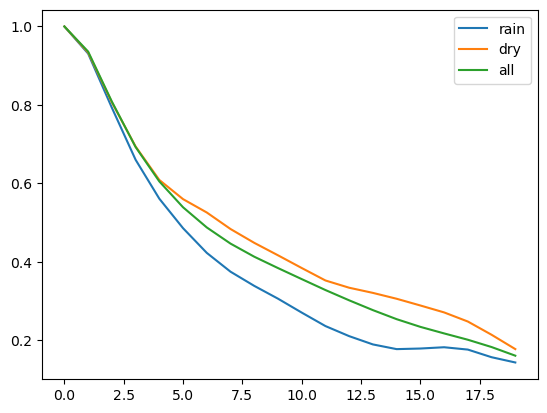

In [2441]:
plt.figure()
plt.plot(autocorre, label="rain")
plt.plot(autocorre_dry, label="dry")

plt.plot(auto_all, label="all")
plt.legend()

# Cross correlation

In [2565]:
def cross_corr_chunked(x, y, lag_max, chunk_size, overlap_size):
    """
    Calculate the cross-correlation between two signals x and y, using overlapping chunks.

    Parameters:
    x, y: Input signals to calculate cross-correlation.
    lag_max: Maximum number of lags to compute.
    chunk_size: Size of each chunk (default is 128).
    overlap_size: Number of points to overlap between chunks (default is 64).

    Returns:
    lags: Array of lag values.
    mean_corr: Averaged cross-correlation across all chunks.
    """
    step_size = chunk_size - overlap_size
    num_chunks = (len(x) - overlap_size) // step_size  # Number of chunks with overlap
    print(num_chunks)
    corr_matrix = np.zeros((num_chunks, 2 * lag_max + 1))  # Store cross-correlation for each chunk

    for i in range(num_chunks):
        start = i * step_size
        end = start + chunk_size

        if end > len(x) or end > len(y):  # Avoid going beyond the signal length
            break

        # Extract the chunk from x and y
        x_chunk = x[start:end]
        y_chunk = y[start:end]

        # Compute the cross-correlation for the current chunk        
        corr = np.correlate(x_chunk-np.mean(x_chunk), y_chunk-np.mean(y_chunk), mode='full')
        mid  = len(corr) // 2
        chunk_corr = corr[mid-lag_max:mid+lag_max+1] / (len(x_chunk) * np.std(x_chunk) * np.std(y_chunk))

        # Store the chunk correlation
        corr_matrix[i, :] = chunk_corr

    # Average the cross-correlation across all chunks
    mean_corr = np.mean(corr_matrix, axis=0)
    lags = np.arange(-lag_max, lag_max + 1)

    return lags, mean_corr

In [2619]:
# Set the parameters for chunking and overlap
auto_length = 100
chunk_size =  128 # 128  # Set your chunk size here
overlap_size = 64 # 64  # Set your overlap size here


In [2620]:
# 獲取緯度範圍 (範圍 -20° ~ 20°)
lat_coarse = np.linspace(-90,90,360)
lat_tropic = (lat_coarse >= -10) & (lat_coarse <= 10)  # ✅ 修正布林索引

# 選取該範圍內的降水數據
precip_tropic_for_cross = precip[:, lat_tropic, :] * np.cos(np.deg2rad(lat_coarse[lat_tropic]))[np.newaxis, :,np.newaxis] **0.5   # ✅ 使用布林索引選取

# 計算經度平均 (Zonal Mean, 沿著 axis=1 方向計算)
precip_tropic_zonal_mean_for_cross = np.average(precip_tropic_for_cross, axis=(1,2)) #.mean(axis=(1,2))  # ✅ 計算熱帶區域的經向平均


In [2621]:
PC1_final    = (PC1 - PC1.mean()) / PC1.std()
precip_final = (precip_tropic_zonal_mean_for_cross - precip_tropic_zonal_mean_for_cross.mean())/precip_tropic_zonal_mean_for_cross.std()

In [2622]:
precip_tropic_zonal_mean_for_cross.shape

(7670,)

In [2623]:
lags, cross_corr_values   = cross_corr_chunked(PC1_final, precip_final, auto_length, chunk_size, overlap_size)


118


(-30.0, 30.0)

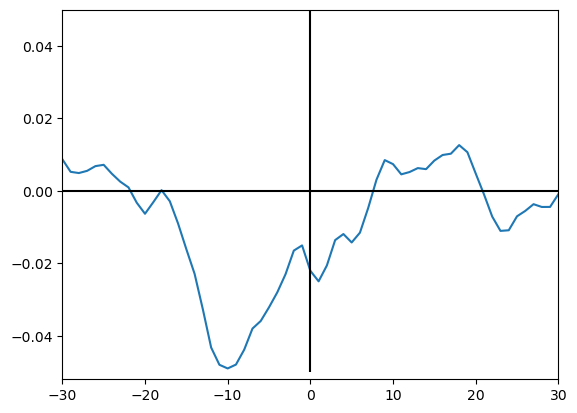

In [2624]:
plt.figure()
plt.plot(lags, cross_corr_values)
plt.hlines(y=0, xmin=-100,xmax=100, lw=1.5, color="Black")
plt.vlines(x=0, ymin=-0.05,ymax=0.05, lw=1.5, color="Black")
plt.ylim([-0.052,0.05])
plt.xlim([-30,30])

In [1200]:
rain_event_mask

array([0., 0., 0., ..., 0., 0., 0.])

In [1201]:
auto_corr_dry.shape

(237, 20)

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan])

{'Rainy Windows': 3, 'Normal Windows': 3, 'Dry Windows': 1}

In [1423]:
mean_auto_corr_rain

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan])